# Rough volatility

In [1]:
import requests, zipfile, io, os

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from scipy.stats import norm
from sklearn.linear_model import LinearRegression

In [4]:
from research.config import plots

In [5]:
plots.init(7, 5, dpi=120)

In [6]:
plots.toggle_grid(True)
plots.toggle_spines(True, True)

## Modeling log-volatility [Gatheral 2018]

### Fractional brownian motion (fBm)

A fractional brownian motion with a Hurst exponent $H\in ]0, 1[$ is a continuous centered Gaussian process with stationnary but not independant increments, having a covariance function:

$$ \mathbb{C}ov(W_t^H, W^H_s) = \frac{1}{2} \left( t^{2H} + s^{2H} - \lvert t-s\rvert^{2H} \right) $$

One can express the fBm as a function of the Brownian motion using the Mamdelbrot-Van Ness representation:

$$ W^H_t = \int_0^t \frac{dWs}{(t-s)^{\frac{1}{2} - H}} + \int_{-\infty}^0 \left(  \frac{1}{(t-s)^{\frac{1}{2} - H}}-\frac{1}{(-s)^{\frac{1}{2} - H}} \right) dW_s $$

Recall the expression of the $p$-th moments of the increments of a fractional brownian motion:

$$ \mathbb{E}\left(\lvert W^H_{t+\delta} - W^H_t\rvert^p\right) = K_p \delta^{pH} $$

Where $ K_p = \mathbb{E}(\lvert Z \rvert^p) $ and $Z\sim \mathcal{N}(0, 1)$
An estimator of the above quantity, given a time horizon $[0, T]$, is:

$$ E_p^\delta = \frac{1}{\lfloor T/\delta\rfloor} \sum_{i=1}^{\lfloor T/\delta\rfloor} \lvert W^H_{\delta i} - W^H_{\delta i-1} \rvert^p$$

### The RFSV model
The idea is to model the log volatility as an fBm with a Hurst exponent $H$ possibly different from $\frac{1}{2}$. However, we always seek stationnary processes for statistical tractability, hence, the log-volatility is rather modeled using a fractional OU process (fOU). In other words: 

$$ \sigma_t = \sigma e^{X_t} $$

Where $X_t$ is a fOU process defined as:

$$ dX_t = \mu dW_t^H - \alpha(X_t - m)dt$$

Gatheral et Al. showed that for small $\alpha$ the log-volatility process still behave like an fBm.

Assuming stationnary increments of the log-volatility, one can rely on $E_p^\delta$ to get an estimate of the parameters using proxies of the unobservable volatility.

## Applications

### Using the Oxford Man realized volatility as proxies

In [7]:
file_name = 'OxfordManRealizedVolatilityIndices.csv'

In [8]:
if not os.path.exists(file_name):
    response = requests.get('https://realized.oxford-man.ox.ac.uk/images/oxfordmanrealizedvolatilityindices-0.2-final.zip')
    z = zipfile.ZipFile(io.BytesIO(response.content))
    z.extractall('.')
else:
    print('file exist')

file exist


In [9]:
rvar = pd.read_csv(file_name, skiprows=[0, 1], index_col=0)

In [10]:
index = 'SPX2.rk'

In [11]:
rvar.index.name = 'Days'
rvar.index = pd.to_datetime(rvar.index, format='%Y%m%d')
rvar = rvar.loc[:, index]

In [12]:
index = index.split('.')[0]

In [13]:
vol = np.sqrt(rvar)
log_vol = np.log(vol)

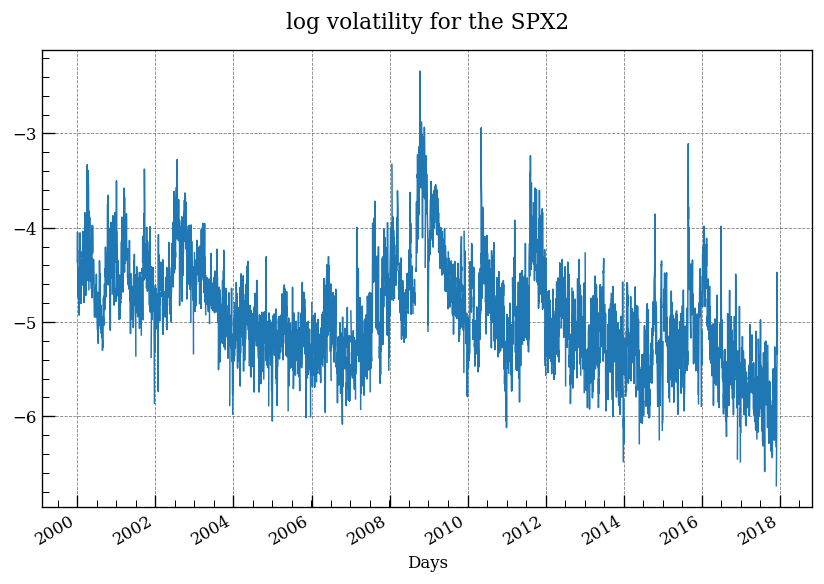

In [14]:
log_vol.plot();
plt.title(f'log volatility for the {index}');

In [15]:
vol = vol.reset_index(drop=True)
log_vol = log_vol.reset_index(drop=True)

#### Moments of order p

In [16]:
def pth_moment(series, delta, p):
    return series.diff(delta).dropna().abs().pow(p).mean()

In [17]:
p_range = [.5, 1, 1.5, 2, 3]
delta_range = np.arange(1, 51)

log_rvs = pd.DataFrame(index=delta_range, columns=p_range)

for delta in delta_range:
    for p in p_range:
        log_rvs.loc[delta, p] = np.log(pth_moment(log_vol, delta, p=p))

In [18]:
log_delta_range = np.log(delta_range).reshape(-1,1)

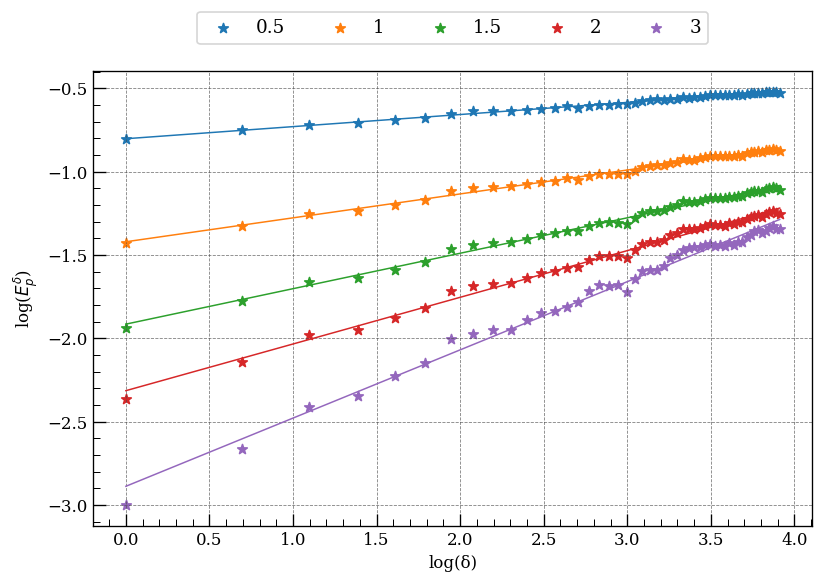

In [19]:
slopes = np.zeros(len(p_range))

for i, p in enumerate(p_range):
    plt.scatter(log_delta_range, log_rvs[p], marker='*', label=p);
    model = LinearRegression().fit(log_delta_range, log_rvs[p])
    α = model.intercept_
    slopes[i] = β = model.coef_
    plt.plot(log_delta_range, (α + β * log_delta_range), label=None)

plt.legend(bbox_to_anchor=[0.5, 1.15], loc='upper center', ncol=5)
    
plt.xlabel('log(δ)');
plt.ylabel('log($E_p^\delta$)');

#### Hurst exponent estimation

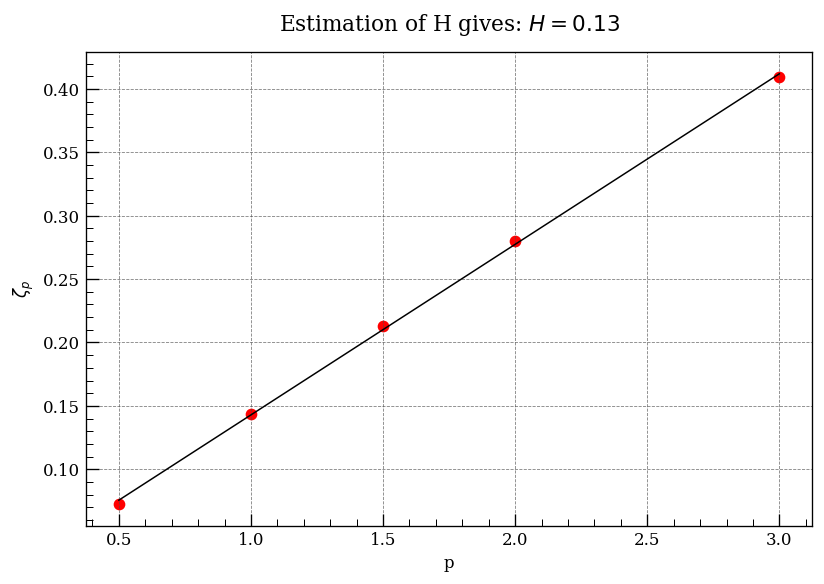

In [20]:
x = np.asarray(p_range).reshape(-1, 1)
y =  slopes.reshape(-1, 1)

model = LinearRegression().fit(x,y)
H = model.coef_[0,0]
c = model.intercept_

plt.scatter(x, y, color='red');
plt.plot(x, c+ H * x, color='black')
plt.title(f'Estimation of H gives: $H={H:.2f}$');
plt.xlabel('p')
plt.ylabel('$\zeta_p$');

#### Normality of log-volatility increments

In [21]:
def density_hist(data, lag, dist, delta, ax):
    y = data.diff(lag)
    xstd = y.std()
    xmean = y.mean()
    x = np.linspace(xmean-5*xstd, xmean+5*xstd, 1000)
    diff = data.diff()
    m = diff.mean()
    σ =  diff.std() * np.power(delta, H)
    d1_rescaled_pdf = dist(m, σ).pdf(x)
    hist_params = dict(density=True, bins=50, 
                       edgecolor='darkgray',
                       color='white', alpha=.5)
    
    line_params1 = dict(lw=1.5, color='red', alpha=.7)
    line_params2 = dict(lw=1.5, color='black', ls='-.')
    
    ax.hist(y, **hist_params)
    ax.plot(x, dist(xmean, xstd).pdf(x), **line_params1)
    ax.plot(x, d1_rescaled_pdf, **line_params2)

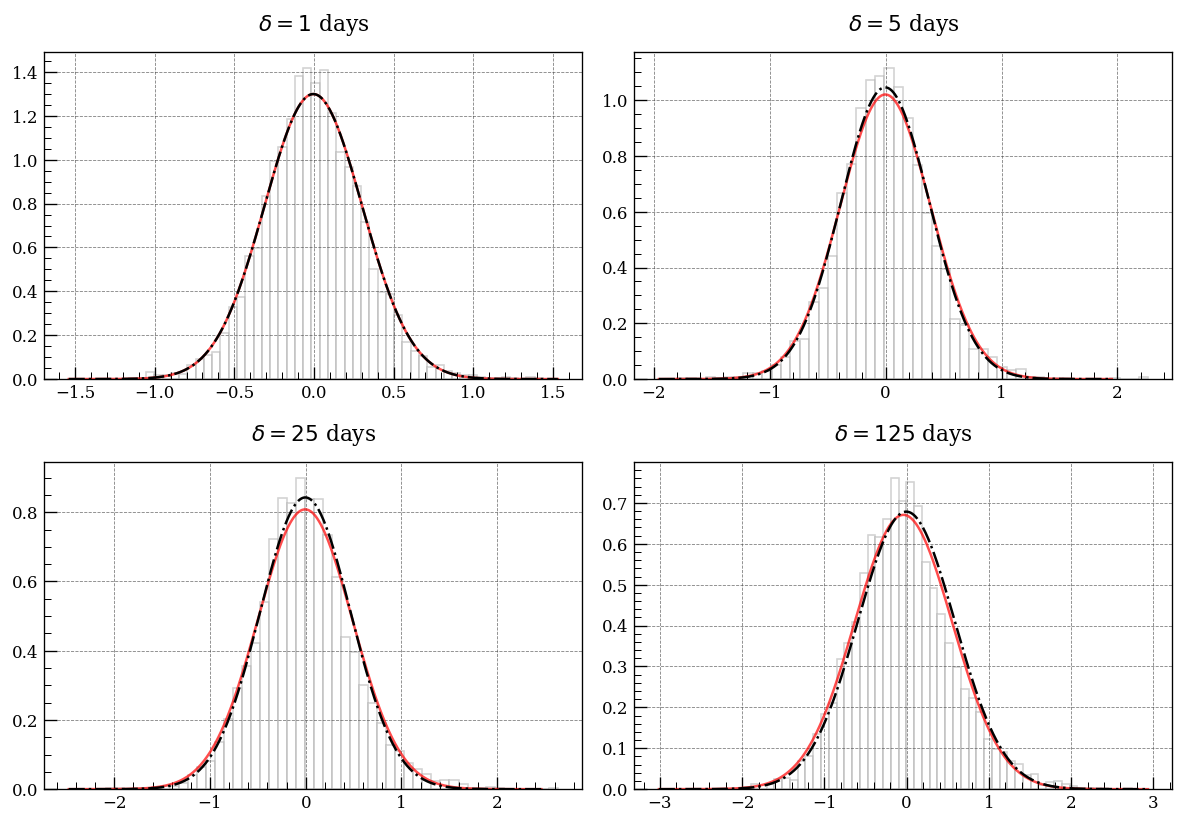

In [22]:
fig, axes = plt.subplots(2, 2, figsize=[10, 7])

axes = axes.flatten()

for i, lag in enumerate([1, 5, 25, 125]):
    density_hist(log_vol, lag, norm, lag, axes[i])
    axes[i].set_title(f'$\delta = {lag}$ days');


#### The autocovariance function of the RFSV model

Another property that matches what we observe in practice is the fact that the autocovariance function of the log-volatility process is linear in $\delta^{2H}$. The same goes for $\log \mathbb{E}(\sigma_t\sigma_{t+\delta})$ since:

$$ \mathbb{E}(\sigma_t\sigma_{t+\delta}) \approx_{\alpha\sim 0} e^{2[\mathbb{E}(X_t^\alpha)+\mathbb{V}(X_t^\alpha)]}e^{-\nu^2\frac{\delta^{2H}}{2}} $$

In [23]:
autocovar = pd.Series(index=delta_range, dtype=float)
log_exp_vol_vol = pd.Series(index=delta_range, dtype=float)
log_autocov = pd.Series(index=delta_range, dtype=float)

for delta in delta_range:
    slv = log_vol.shift(-delta)
    sv = vol.shift(-delta)
    mplv = log_vol.mean() * slv.mean()
    mpv = vol.mean() * sv.mean()
    autocovar[delta] = log_vol.mul(slv).mean() - mplv
    log_exp_vol_vol[delta] = np.log(sv.mul(vol).mean())
    log_autocov[delta] = np.log(vol.mul(sv).mean() - mpv)

In [24]:
x0 = np.power(delta_range, 2*H).reshape(-1,1)
x1 = np.log(delta_range).reshape(-1,1)

y1 =  autocovar
y2 = log_exp_vol_vol
y3 = log_autocov

model1 = LinearRegression().fit(x0,y1)
model2 = LinearRegression().fit(x0,y2)
model3 = LinearRegression().fit(x1,y3)

s1 = model1.coef_[0]
c1 = model1.intercept_

s2 = model2.coef_[0]
c2 = model2.intercept_

s3 = model3.coef_[0]
c3 = model3.intercept_

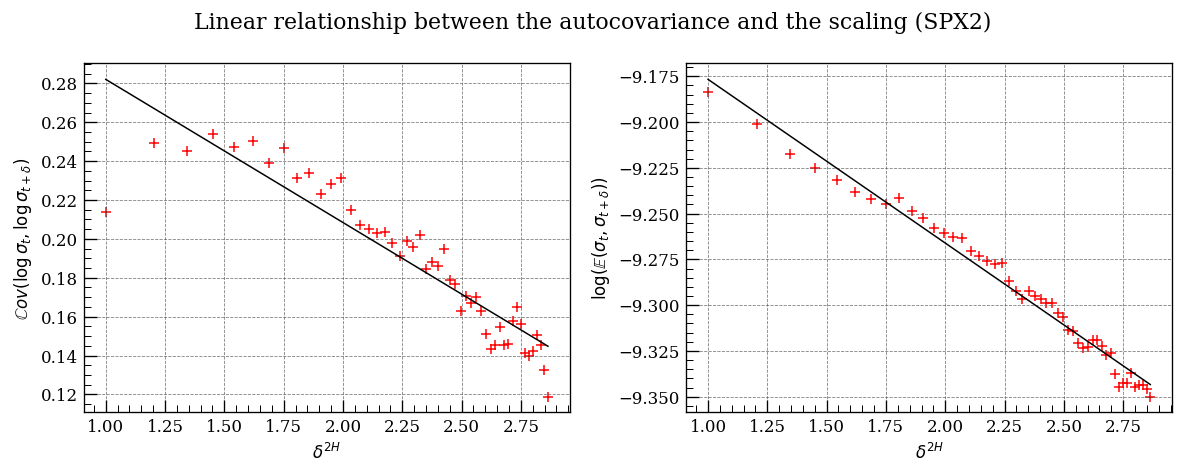

In [25]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=[10, 4])

ax1.scatter(x0, y1, marker='+', c='red')
ax2.scatter(x0, y2, marker='+', c='red')

ax1.plot(x0,  c1 +s1*x0, color='black');
ax2.plot(x0,  c2 +s2*x0, color='black');

ax1.set_xlabel('$\delta^{2H}$')
ax1.set_ylabel('$\mathbb{C}ov(\log\sigma_t, \log\sigma_{t+\delta})$');

ax2.set_xlabel('$\delta^{2H}$')
ax2.set_ylabel('$\log(\mathbb{E}(\sigma_t, \sigma_{t+\delta}))$');

fig.suptitle(f'Linear relationship between the autocovariance and the scaling ({index})');

However, no power-law decay:

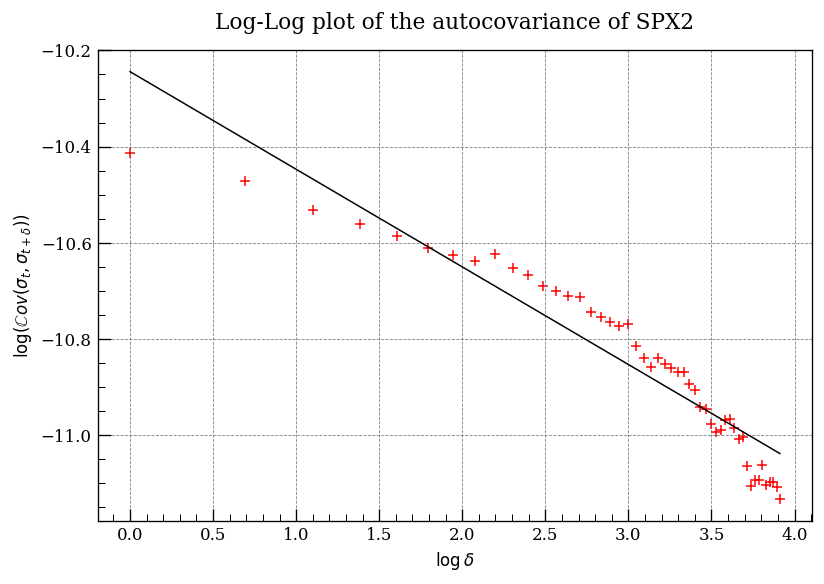

In [26]:
plt.scatter(x1, y3, marker='+', c='red')
plt.plot(x1,  c3 +s3*x1, color='black');
plt.xlabel('$\log\delta$')
plt.ylabel('$\log(\mathbb{C}ov(\sigma_t, \sigma_{t+\delta}))$');

plt.title(f'Log-Log plot of the autocovariance of {index}');

### Using high frequency data

In this part we compute the daily integrated volatility computed using last traded price between 10 and 11 am.

In [27]:
stock = 'TOTAL'
file_name = f'../../datasets/orderbook/{stock}.h5'

lob = pd.read_hdf(file_name)

In [28]:
lob.head()

,TradedPrice,TradedQty,BidPrice,AskPrice,BidQty,AskQty,TradedSign
Time,,,,,,,
2011-01-03 09:00:01.988,40.19,70,40.01,40.19,660800,40700,1
2011-01-03 09:00:01.988,40.19,15,40.01,40.19,660800,40700,1
2011-01-03 09:00:01.988,40.19,67,40.01,40.19,660800,40700,1
2011-01-03 09:00:01.988,40.19,20,40.01,40.19,660800,40700,1
2011-01-03 09:00:01.988,40.19,250,40.01,40.19,660800,40700,1


In [29]:
traded_price = lob.TradedPrice.groupby('Time').last()

In [30]:
price = np.log(
    traded_price
    .between_time('10:00', '11:00')
    .replace(0, np.nan)
    .dropna()
)

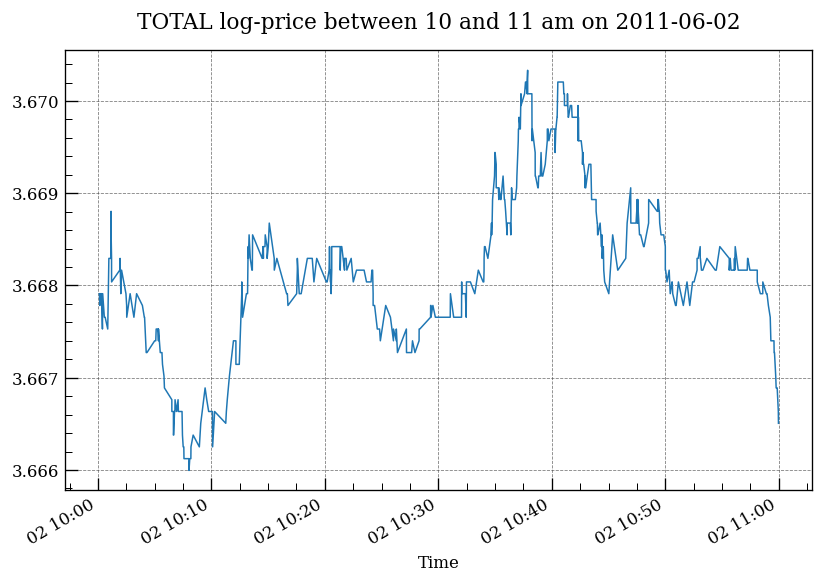

In [31]:
date = '2011-06-02'
price.loc[date].plot(title=f'{stock} log-price between 10 and 11 am on {date}');


In [32]:
def quadratic_variation(series):
    return series.diff().pow(2).sum()

In [33]:
def garman_klass(series, freq='15T'):
    ohlc = series.resample(freq).ohlc().dropna()
    hilo = (ohlc['high'] - ohlc['low']).pow(2)
    coop = (ohlc['close'] - ohlc['open']).pow(2)
    return (.5 * hilo - (2 * np.log(2) - 1) * coop).sum()

In [34]:
# Naive estimators (Quadratic variation / Garman Klass on reasonable time increments
# Use UZ model instead or estimators from Ait Sahalia and Jacod
price = np.log(
    traded_price
    .resample('15T')
    .last()
    .replace(0, np.nan)
    .dropna()
)

In [35]:
rvar = price.groupby(pd.Grouper(freq='1D'), dropna=True).apply(quadratic_variation)
vol = np.sqrt(rvar.replace(0, np.nan).dropna())
log_vol = np.log(vol)

In [36]:
# Garman Klass estimator
groups = np.log(traded_price).groupby(pd.Grouper(freq='1D'), dropna=True)
rvar_gk = pd.Series([np.sqrt(garman_klass(g)) for _, g in groups if len(g) > 0], index=vol.index)

In [37]:
vol_gk = rvar_gk
log_vol_gk = np.log(vol_gk)

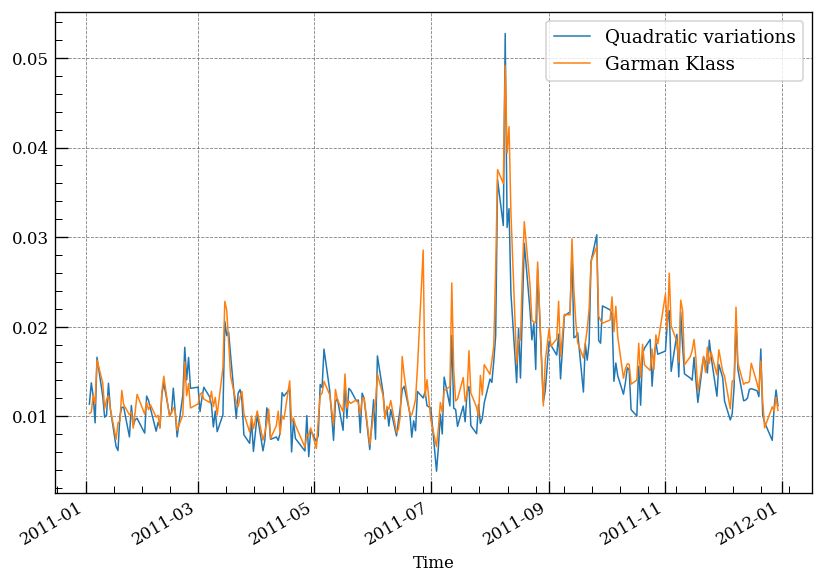

In [45]:
vol.plot(label='Quadratic variations');
vol_gk.plot(label='Garman Klass');
plt.legend();

In [39]:
p_range = [.5, 1, 1.5, 2, 3]
delta_range = np.arange(1, 51)

log_rvs = pd.DataFrame(index=delta_range, columns=p_range)
log_rvs_gk = pd.DataFrame(index=delta_range, columns=p_range)
for delta in delta_range:
    for p in p_range:
        log_rvs.loc[delta, p] = np.log(pth_moment(log_vol, delta, p=p))
        log_rvs_gk.loc[delta, p] = np.log(pth_moment(log_vol_gk, delta, p=p))

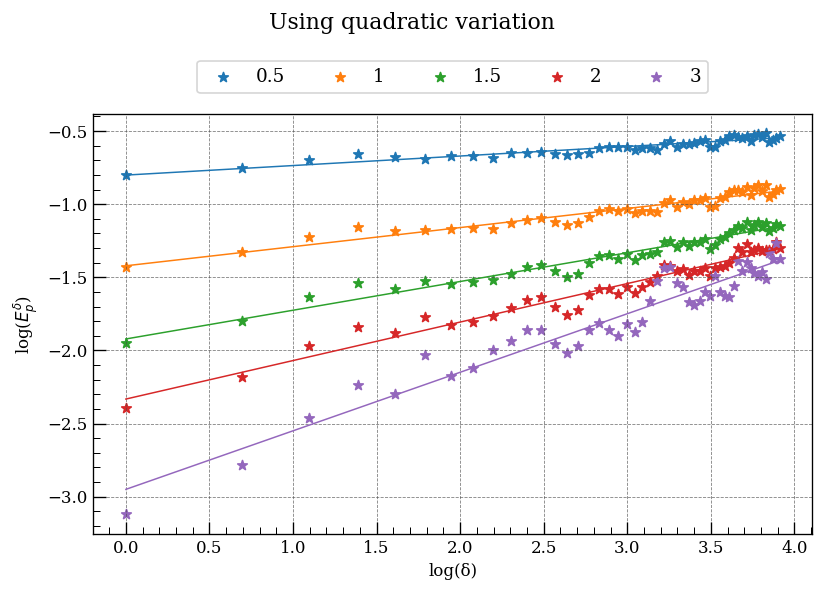

In [40]:
slopes = np.zeros(len(p_range))

for i, p in enumerate(p_range):
    plt.scatter(log_delta_range, log_rvs[p], marker='*', label=p);
    model = LinearRegression().fit(log_delta_range, log_rvs[p])
    α = model.intercept_
    slopes[i] = β = model.coef_
    plt.plot(log_delta_range, (α + β * log_delta_range), label=None)

plt.legend(bbox_to_anchor=[0.5, 1.15], loc='upper center', ncol=5)
    
plt.xlabel('log(δ)');
plt.ylabel('log($E_p^\delta$)');
plt.suptitle('Using quadratic variation');


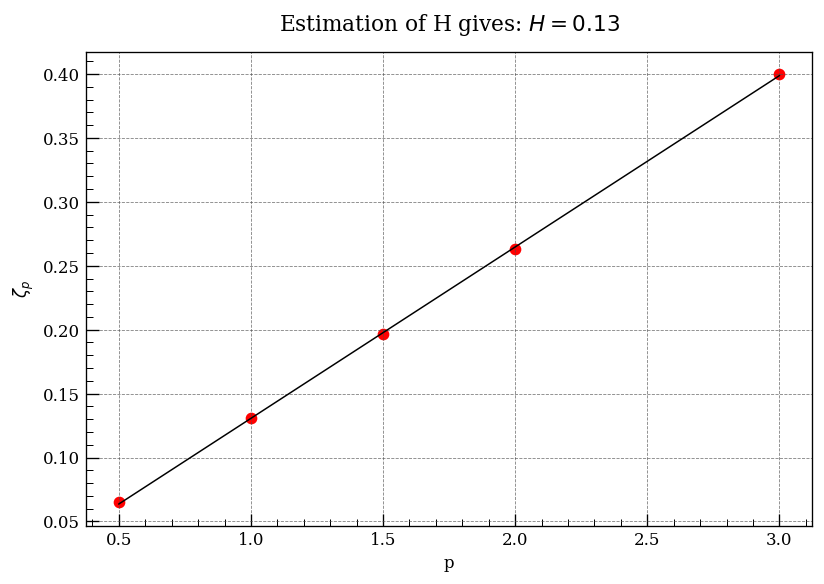

In [41]:
x = np.asarray(p_range).reshape(-1, 1)
y =  slopes.reshape(-1, 1)

model = LinearRegression().fit(x,y)
H = model.coef_[0,0]
c = model.intercept_

plt.scatter(x, y, color='red');
plt.plot(x, c+ H * x, color='black')
plt.title(f'Estimation of H gives: $H={H:.2f}$');
plt.xlabel('p')
plt.ylabel('$\zeta_p$');

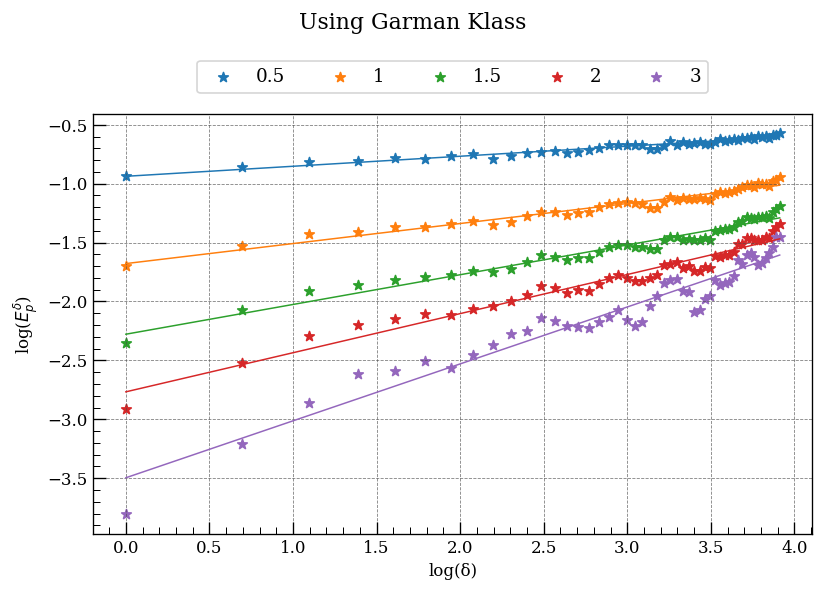

In [42]:
slopes = np.zeros(len(p_range))

for i, p in enumerate(p_range):
    plt.scatter(log_delta_range, log_rvs_gk[p], marker='*', label=p);
    model = LinearRegression().fit(log_delta_range, log_rvs_gk[p])
    α = model.intercept_
    slopes[i] = β = model.coef_
    plt.plot(log_delta_range, (α + β * log_delta_range), label=None)

plt.legend(bbox_to_anchor=[0.5, 1.15], loc='upper center', ncol=5)
    
plt.xlabel('log(δ)');
plt.ylabel('log($E_p^\delta$)');
plt.suptitle('Using Garman Klass');


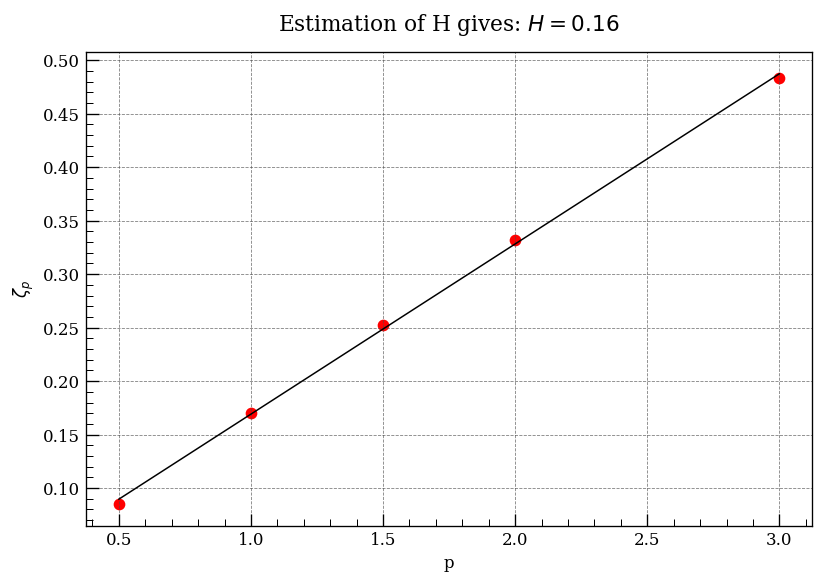

In [43]:
x = np.asarray(p_range).reshape(-1, 1)
y =  slopes.reshape(-1, 1)

model = LinearRegression().fit(x,y)
H = model.coef_[0,0]
c = model.intercept_

plt.scatter(x, y, color='red');
plt.plot(x, c+ H * x, color='black')
plt.title(f'Estimation of H gives: $H={H:.2f}$');
plt.xlabel('p')
plt.ylabel('$\zeta_p$');

#### Estimating the hurst exponent using the normalized $p^{th}$ variation [Cont 2021]:

We consider the statistic:

$$
    W(L, K \pi, p, t, X) := \sum_{\pi^K \cap [0, t]} \frac{\lvert X(t_{i+1}^K) - X(t_{i}^K)\rvert^p}{\sum_{\pi^L \cap [t_i^K, t_{i+1}^K]} \lvert X(t_{i+1}^L) - X(t_{i}^L)\rvert^p} \times (t_{i+1}^K - t_i^K)
$$

$K$ is the block frequency (ex. every 5 minutes). $L$ is the frequency of the data (ex. every millisecond).

as the block and sample frequency increase $W$ converges to the normalized $p^{th}$ variation.

To get the Hurst estimate, we need to find the order $\hat p$ such that $W = T$ and define:
$$\hat H = \frac{1}{\hat p}$$

See the paper of Rama Cont: Rough volatility, fact or artefact? for more details.

In [44]:
# TODO